#### Funciones

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import sympy as sym

#Función para limpiar los datos
def limpiarDatos(datos):
  """
    Cumple la función de limpiar listas de datos de datos no numéricos mediante math.isfinite()

    Parámetros:
    - datos(lista): lista ingresada por el usuario con datos numéricos

    Retorna:
    - datosLimpios(lista): lista ingresada sin valores nan
  """
  datosLimpios = []
  for dato in datos:
    if math.isfinite(dato):
      datosLimpios.append(dato)

  return datosLimpios

def eliminarDuplicados(tiempo): #se usa después de procesar los datos y limpiar lista tiempo de nans
  """
    Elimina los tiempos duplicados de la lista ingresada

    Parámetros:
    - tiempo(lista): lista de tiempos ingresada

    Retorna:
    - indicesClean(lista): lista con los índices de los tiempos no duplicados
  """
  listaClean = []
  indicesClean = []

  for i in range(len(tiempo)):
      elem = str(tiempo[i]).split(".")[0] #el tiempo se formatea 1323.0000002
      #son duplicados los que empiezan igual antes de el punto.

      if elem not in listaClean:
          listaClean.append(elem)
          indicesClean.append(i) # de vuelve los indices

  return indicesClean


def procesar_linea(elementos, tiempo, frecuencia, incertezas):
  """
    Procesa una línea del archivo dependiendo de su longitud

    Parámetros:
    - elementos(lista): línea de un archivo obtenida con readlines()
    - tiempo(lista): lista que incluirá los tiempos la línea procesada
    - frecuencia(lista): lista que incluirá las frecuencias la línea procesada
    - incertezas(lista): lista que incluirá las posibles incertezas que se encuentren en la línea procesada

    Retorna:
    - tiempo(lista), frecuencia(lista), incertezas(lista): las listas con los datos ingresados desde elementos
  """
  datosLinea = elementos.split()

  # Verificar si la línea no está vacía
  if not datosLinea:
      print(f"Advertencia: línea vacía ignorada.")
      return tiempo, frecuencia, incertezas

  if len(datosLinea) == 3:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
          incertezas.append(float(datosLinea[2]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")

  elif len(datosLinea) == 2:
      try:
          tiempo.append(float(datosLinea[0]))
          frecuencia.append(float(datosLinea[1]))
      except ValueError:
          print(f"Advertencia: no se pudo convertir los valores a float en la línea: {elementos}")

  else:
      print(f"Advertencia: número de columnas inesperadas en la línea: {elementos}")

  return tiempo, frecuencia, incertezas


def leerArchivo(archivo):
  """
    Lee el archivo y procesa sus datos en 3 listas: tiempos, frecuencias, e incertezas

    Parámetros:
    - archivo(file): ruta de acceso al archivo que se desea leer

    Retorna:
    - tiempoClean(lista): lista de tiempo sin duplicados
    - frecuenciaClean(lista): lista de frecuencias acorde a tiempoCLean
    - incertezasClean(lista): En caso de que presente incertezas, devuelve una lista de incertezas sin Nan
  """
  with open(archivo, "r") as lectura:
      listaDatos = lectura.readlines()

  tiempo = []
  frecuencia = []
  incertezas = []

  # Procesar cada línea del archivo
  for elementos in listaDatos:
      tiempo, frecuencia, incertezas = procesar_linea(elementos, tiempo, frecuencia, incertezas)

  # Limpiar los datos de posibles Nans
  tiempoTrue = limpiarDatos(tiempo)
  frecuenciaTrue = limpiarDatos(frecuencia)

  # Eliminar los duplicados:
  indices = eliminarDuplicados(tiempoTrue)

  tiempoClean = [tiempoTrue[i] for i in indices]
  frecuenciaClean = [frecuenciaTrue[i] for i in indices]


  # Si hay incertezas, limpiarlas también
  if incertezas:

      incertezasTrue = limpiarDatos(incertezas)
      incertezasClean = [incertezasTrue[i] for i in indices]


      return tiempoClean, frecuenciaClean, incertezasTrue

  else:

      return tiempoClean, frecuenciaClean, []

def ajuste_polinomial(xi,yi,grado=2):
  """
    Realiza un ajuste polinomial a un conjunto de datos utilizando el método de mínimos cuadrados.
    Se calcula el polinomio de grado especificado que mejor se ajusta a los puntos dadosy retorna los residuos
    entre los datos ingresados y los ajustados

    Parámetros:
    - xi(lista o np.array): lista o arreglo de valores de las coordenadas x de los datos.
    - yi(lista o np.array): lista o arreglo de valores de las coordenadas y de los datos.
    - grado(int) : grado del ajuste del polinomio, grado 2 por defecto

    Retorna:
    - residuo(lista): arreglo que contiene los residuos, transformado a lista con la función list()
  """

  m = grado

  # PROCEDIMIENTO
  xi = np.array(xi)
  yi = np.array(yi)
  n  = len(xi)

  # llenar matriz A y vector B
  k = m + 1
  A = np.zeros(shape=(k,k),dtype=float)
  B = np.zeros(k,dtype=float)

  for i in range(0,k,1):
      for j in range(0,i+1,1):
          coeficiente = np.sum(xi**(i+j))
          A[i,j] = coeficiente
          A[j,i] = coeficiente
      B[i] = np.sum(yi*(xi**i))

  # coeficientes, resuelve sistema de ecuaciones
  C = np.linalg.solve(A,B)

  # polinomio
  x = sym.Symbol('x')
  f = 0
  fetiq = 0
  for i in range(0,k,1):
      f = f + C[i]*(x**i)
      fetiq = fetiq + np.around(C[i],4)*(x**i)

  fx = sym.lambdify(x,f)
  fi = fx(xi)

  residuo = np.array(yi)-np.array(fi)

  return list(residuo)

def ajuste_residuos_lineal(tiempo, frecuencia):
  """
    Ajusta una línea recta a los datos de tiempo y frecuencia, y calcula los residuos.

    Parámetros:
    - tiempo: array de valores de tiempo.
    - frecuencia: array de valores de frecuencia.

    Retorna:
    - residuos: array de residuos (diferencia entre los datos y la tendencia ajustada).
    - linea_tendencia: array de valores de la recta ajustada (tendencia).
    - m, b: coeficientes de la recta ajustada (pendiente y el intercepto).
  """
  # Convertir las listas de entrada en arrays de numpy (en caso de que no lo sean)
  arrayTiempo = np.array(tiempo)
  arrayFrecuencia = np.array(frecuencia)

  # Calcular las sumas necesarias para el sistema de ecuaciones
  x = np.sum(arrayTiempo)
  y = np.sum(arrayFrecuencia)
  xy = np.sum(arrayFrecuencia * arrayTiempo)
  x2 = np.sum(arrayTiempo ** 2)

  # Calcular la pendiente m y el intercepto b usando las fórmulas del ajuste lineal
  m = (len(tiempo) * xy - x * y) / (len(tiempo) * x2 - x ** 2)
  b = (y * x2 - x * xy) / (len(tiempo) * x2 - x ** 2)

  # Ecuación de la recta ajustada
  linea_tendencia = m * arrayTiempo + b

  # Calcular los residuos (diferencia entre los datos reales y la tendencia ajustada)
  residuos = arrayFrecuencia - linea_tendencia

  return residuos, m, b

def obtener_glitches_y_tiempos(tiempo, residuos, nombre, paso=1):
  """
    Grafica el residuo de los datos frente al tiempo junto a los post y pre glitches encontrados con find_peaks
    Busca la magnitud de los glitches y el tiempo en el que ocurren

    Parámetros:
    - tiempo(lista): lista con el tiempo registrado de la frecuencia
    - residuos(lista): lista con los residuos del ajuste al gráfico de frecuenciaVsTiempo
    - nombre(string): nombre del púlsar ingresado
    - paso(int): valor de paso entre peaks, valor 1 por defecto

    Datos:
    - tiemposInd(lista): lista con los tiempos de los post-glitches
    - peaksInd(lista): lista con los valores de la frecuencia de los post-glitches
    - tiemposNegaInd(lista): lista con los tiempos de los pre-glitches
    - peaksNega(lista): lista con los valores de la frecuencia de los pre-glitches

    Retorna:
    - tiemposTrue(lista): lista con el promedio de tiempos de cada post y preglitch (tiempo exacto de cada glitch)
    - magGlitch(lista): lista con la magnitud de cada glitch
  """

  # Find peaks y listas con indices correspondientes
  peaksDatos = find_peaks(residuos, distance=paso)

  tiemposInd = [ tiempo[i] for i in peaksDatos[0] ]
  peaksInd = [ residuos[i] for i in peaksDatos[0] ]

  # Peaks negativos de los datos
  datosNega = [ (-1)*i for i in residuos]
  peaksNega = find_peaks(datosNega, distance=paso)

  tiemposNegaInd = [ tiempo[j] for j in peaksNega[0] ]
  peaksNegaInd = [ residuos[j] for j in peaksNega[0] ]

  # Cálculo de tiempo y magnitud de los Glitches
  tiemposTrue = []
  magGlitch = []
  for i in range(len(peaksDatos[0])):
    tiemposTrue.append((tiemposInd[i]+tiemposNegaInd[i])/2) #Los tiempos se promedian
    magGlitch.append(peaksInd[i]-peaksNegaInd[i]) #Los post y pre glitches se restan

  #Gráfico de los datos
  fig = plt.figure(figsize=(6,6))

  ax = fig.add_subplot(111)
  ax.plot(tiempo, residuos, linewidth=1, linestyle="--", color="black", alpha=0.5)
  ax.scatter(tiemposInd, peaksInd ,marker="x",color="red",s=10, label="Post-Glitch")
  ax.scatter(tiemposNegaInd, peaksNegaInd, marker="x",color="blue",s=10, label="Pre-Glitch")

  ax.set_title(f"Glitches detectados en {nombre}")
  ax.set_xlabel("Tiempo [MJD]")
  ax.set_ylabel("Glitches")
  ax.legend()
  plt.show()

  return tiemposTrue, magGlitch

In [21]:
# Llamado a la función leerArchivo (Ingresar la ruta para cada archivo)
# Se obtienen los tiempos, frecuencias e incertezas respectivas de cada uno

tiempoB0531, frecuenciaB0531, incertezaB0531 = leerArchivo("/content/frec_B0531.dat")
tiempoB0833, frecuenciaB0833, incertezaB0531 = leerArchivo("/content/frec_B0833 (1).dat")
tiempoJ0537, frecuenciaJ0537, incertezaJ0537 = leerArchivo("/content/frec_J0537.dat")
tiempoJ1819, frecuenciaJ1819, incertezaJ1819 = leerArchivo("/content/frec_J1819.dat")

Advertencia: línea vacía ignorada.


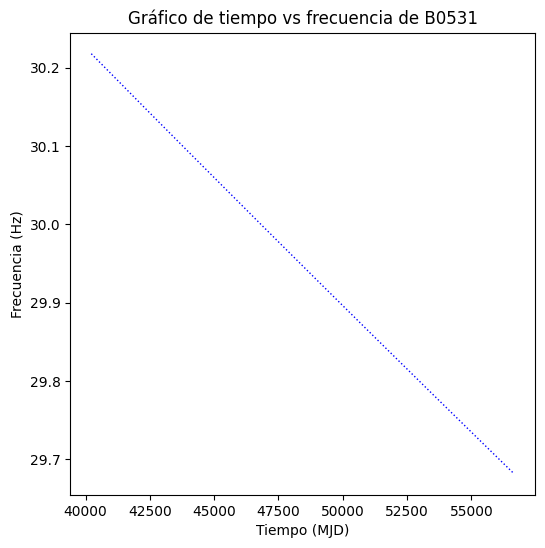

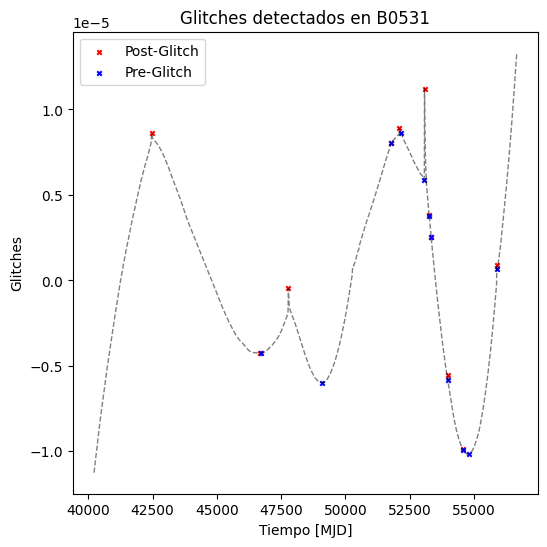

In [22]:
# Púlsar B0531

# Gráfico de frecuencia vs tiempo
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoB0531,frecuenciaB0531,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0531")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

# Cálculo del residuo:
residuoB0531 = ajuste_polinomial(tiempoB0531,frecuenciaB0531, 3)

# Gráfico pre/post-glitches, obtención de magnitud y tiempo de cada Glitch
tiempoGlitchB0531, glitchesB0531 = obtener_glitches_y_tiempos(tiempoB0531, residuoB0531, "B0531", 5)

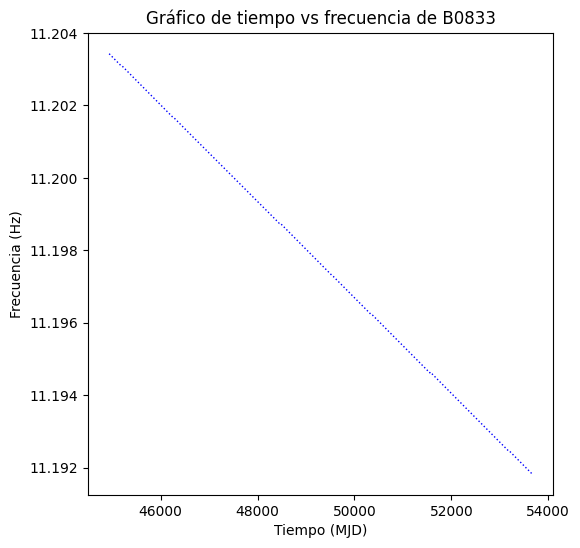

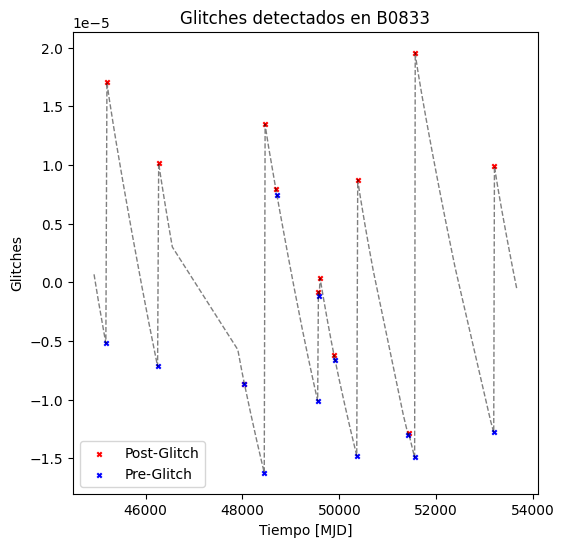

In [23]:
# Púlsar B0833

# Gráfico de frecuencia vs tiempo
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.plot(tiempoB0833, frecuenciaB0833, color="blue", linewidth=1, linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de B0833")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")
plt.show()

# Calcular residuos:
residuoB0833, m, b = ajuste_residuos_lineal(tiempoB0833, frecuenciaB0833)

# Gráfico pre/post-glitches, obtención de magnitud y tiempo de cada Glitch
tiempoGlitchB0833, glitchesB0833 = obtener_glitches_y_tiempos(tiempoB0833, residuoB0833, "B0833")

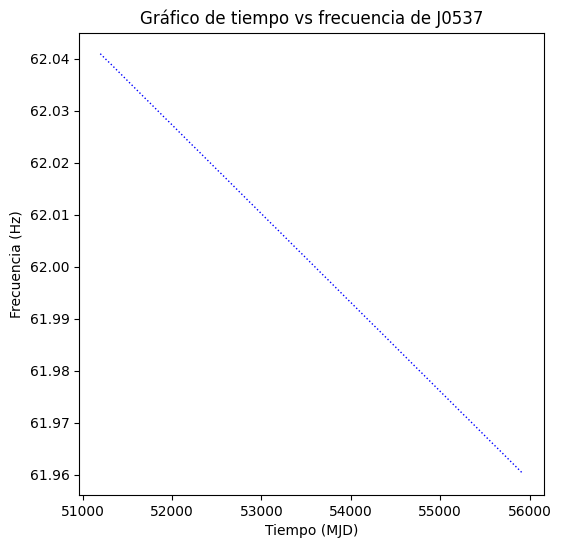

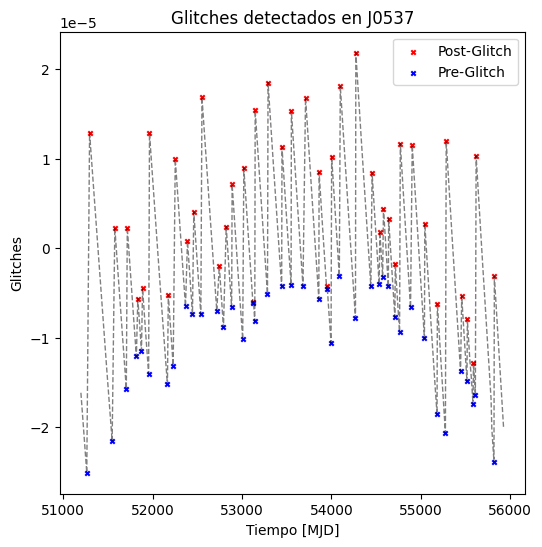

In [24]:
# Púlsar J0537

# Gráfico de frecuencia vs tiempo
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ0537,frecuenciaJ0537,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de J0537")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

# Calcular residuos:
residuoJ0537, m, b = ajuste_residuos_lineal(tiempoJ0537,frecuenciaJ0537)

# Gráfico pre/post-glitches, obtención de magnitud y tiempo de cada Glitch
tiempos, glitches = obtener_glitches_y_tiempos(tiempoJ0537, residuoJ0537, "J0537")


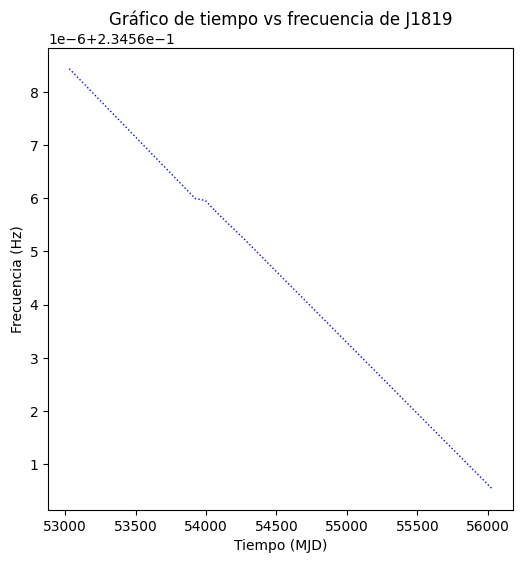

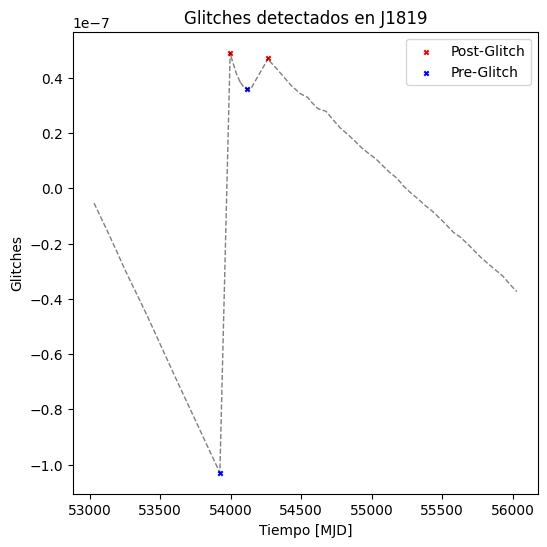

In [25]:
# Púlsar J1819

# Gráfico de frecuencia vs tiempo
fig, ax = plt.subplots(1,1,figsize=(6,6))

ax.plot(tiempoJ1819,frecuenciaJ1819,color="blue",linewidth=1,linestyle="dotted")
ax.set_title("Gráfico de tiempo vs frecuencia de J1819")
ax.set_xlabel("Tiempo (MJD)")
ax.set_ylabel("Frecuencia (Hz)")

plt.show()

# Calcular residuos:
residuoJ1819, m, b = ajuste_residuos_lineal(tiempoJ1819,frecuenciaJ1819)

# Gráfico pre/post-glitches, obtención de magnitud y tiempo de cada Glitch
tiempoGlitchesJ1819, glitchesJ1819 = obtener_glitches_y_tiempos(tiempoJ1819, residuoJ1819, "J1819", 5)

Bienvenido a Glitch Finder!

Desea ingresar datos para analizar?
 1.- Sí   2.- No

Ingrese su opción: 1

Ingrese la dirección del archivo: /content/frec_J0537.dat
Ingrese el nombre de su púlsar: J0537



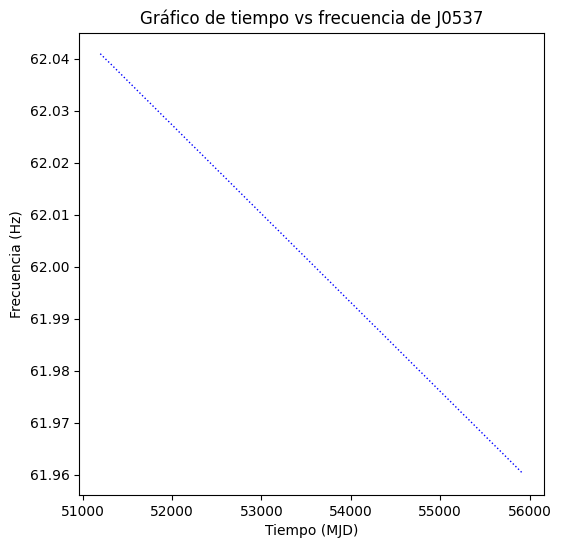


Qué tipo de ajuste desea realizar?
 1.- Lineal   2.- Polinomial

Ingrese su opción: 1

Ingrese el paso entre peaks: 1



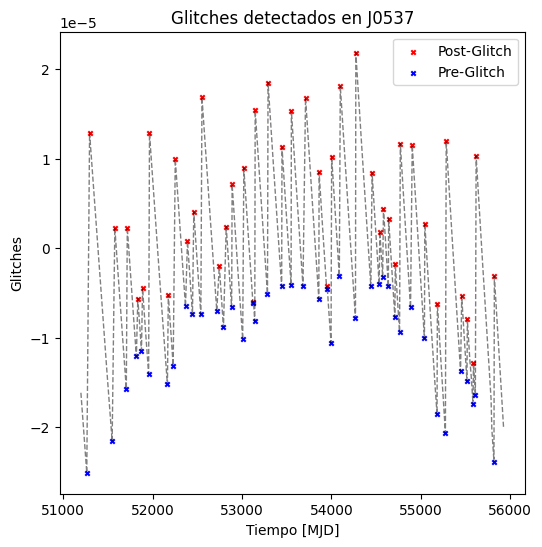


Desea ingresar datos para analizar?
 1.- Sí   2.- No

Ingrese su opción: 2

Gracias por usar Glitch Finder!


In [28]:
#Intefaz para llevar a cabo los gráficos y cálculos con las funciones


#Ciclo para la interfaz principal
flag = True

print("Bienvenido a Glitch Finder!\n")
while flag:
  print("Desea ingresar datos para analizar?\n",
        "1.- Sí   2.- No\n")

  opt = input("Ingrese su opción: ")
  print()

  #Si la opción es 1, se crea otro ciclo para el ingreso del archivo y el nombre del púlsar
  if opt == "1":

    flag2 = True
    while flag2:

      #Input para dirección del archivo y nombre del púlsar
      direccion = input("Ingrese la dirección del archivo: ")
      nombreArchivo = input("Ingrese el nombre de su púlsar: ")
      print()

      #Try y except para aprueba de errores en caso de dirección inválida
      try:
        #Se lee el archivo y se grafican los datos obtenidos
        tiempoArchivo, frecuenciaArchivo, incertezasArchivo = leerArchivo(direccion)
        fig, ax = plt.subplots(1,1,figsize=(6,6))

        ax.plot(tiempoArchivo, frecuenciaArchivo, color="blue",linewidth=1,linestyle="dotted")
        ax.set_title(f"Gráfico de tiempo vs frecuencia de {nombreArchivo}")
        ax.set_xlabel("Tiempo (MJD)")
        ax.set_ylabel("Frecuencia (Hz)")
        plt.show()
        print()
        flag2 = False

      except:
        print("Reingrese sus datos, realmente ingresó una dirección válida?\n")

    #Cuando el ciclo anterior termina, se crea otro para realizar el ajuste según lo que ingrese el usuario
    if flag2 == False:
      flag3 = True
      while flag3:
        print("Qué tipo de ajuste desea realizar?\n",
              "1.- Lineal   2.- Polinomial\n")

        opt2 = input("Ingrese su opción: ")
        print()

        #Si la opción es 1, se realiza el ajuste lineal con solo necesidad de ingresar el paso
        if opt2 == "1":

          pasoPeaks = input("Ingrese el paso entre peaks: ")
          print()
          try:
            residuoArchivo, m, b = ajuste_residuos_lineal(tiempoArchivo,frecuenciaArchivo)
            tiempoGlitchesArchivo, glitchesArchivo = obtener_glitches_y_tiempos(tiempoArchivo, residuoArchivo, nombreArchivo, int(pasoPeaks))
            flag3 = False
            print()

          except:
            print("No se pudo realizar el análisis, intente ingresar un paso válido\n")

        #Si la opción es 2, se realiza el ajuste polinomial de grado ingresado junto al paso deseado
        elif opt2 == "2":

          pasoPeaks = input("Ingrese el paso entre peaks: ")
          grado = input("Ingrese el grado del ajuste polinomial: ")
          print()

          try:
            residuoArchivo = ajuste_polinomial(tiempoArchivo,frecuenciaArchivo, int(grado))
            tiempoGlitchesArchivo, glitchesArchivo = obtener_glitches_y_tiempos(tiempoArchivo, residuoArchivo, nombreArchivo, int(pasoPeaks))
            flag3 = False
            print()

          except:
            print("No se pudo realizar el análisis, intente ingresar un paso válido\n")

        else:
          print("Opción inválida, por favor pruebe de nuevo\n")

  #Si la opción es 2, termina el ciclo
  elif opt == "2":
    print("Gracias por usar Glitch Finder!")
    flag = False

  else:
    print("Opción inválida, por favor pruebe de nuevo\n")
